# Detection et traitement du Bruis

*a.k.a* Denoiser

Dans cette partie, nous allons étudier un système permettant de detecter et de réduire l'infulence du Bruis sur les images dégradés issues des VHS.

Les données d'entrée sont donc des images bruitées issues de la numérisation de VHS. La sortie attendue est la même image mais ayant un bruis atténué voir absent.

Dans ce rapport, nous allons rechercher la meilleur solution permettant de corriger le bruis des images en passant par de multiples solutions. Les bloc de code qui ne permettent pas d'arriver à la solution et qui nécéssitent une grande puissance de calcul seront ignorées pour une bonne lecture de ce rapport.

## Mise en place du Notebook

Ici, nous importons les différentes bibliothèques et définissions les constantes

In [1]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage.color import rgb2hsv, hsv2rgb
from skimage.filters import gaussian
from IPython.display import display
from os import listdir
from os.path import isfile, join
from sklearn.dummy import DummyRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer, confusion_matrix, accuracy_score
from sklearn.linear_model import SGDRegressor
from sklearn.multioutput import MultiOutputRegressor
from keras.models import Sequential
from keras.layers import Dense
from multiprocessing import Pool
from base_functions import img_path2array, img_array2file
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
import pickle

Using TensorFlow backend.


In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
DATASETS_PATH = "../labs/noise-filter/"

source_path = DATASETS_PATH+"clean_base"
ref_out = DATASETS_PATH+"clean_splitted"
noise_out = DATASETS_PATH+"noisy_splitted"
isolated_out = DATASETS_PATH+"noisy_isolated"
detection_train_path = DATASETS_PATH+"detection_train"
NEIGHBOURS=20

Tout les datasets de ce notebooks seront stockés dans le dossier `Labs/noise-filter`

In [3]:
def show_img(imga):
    display(Image.fromarray(np.interp(imga,(0,1), (0,255)).astype("uint8")))

In [4]:
!rm -rf ../labs/noise-filter
!mkdir -p ../labs/noise-filter
!mkdir -p ../labs/noise-filter/clean_base
!cp -f ../dataset_clean_degraded/clean/* ../labs/noise-filter/clean_base
!mkdir -p ../labs/noise-filter/clean_splitted
!mkdir -p ../labs/noise-filter/noisy_splitted
!mkdir -p ../labs/noise-filter/noisy_isolated
!mkdir -p ../labs/noise-filter/detection_train

# Correction

Dans un premier temps, nous allons concevoir un système permettant de corriger le bruit présent sur une image.

## CRISP Itéraion 1

### Exploration des données

On peut alors tirer quelques images ayant du bruis

|                                  |                                  |
|----------------------------------|----------------------------------|
|![Image 1](../dataset/0001.jpg)   | ![Image 7](../dataset/0007.jpg)  |
|![Image 76](../dataset/0076.jpg)  | ![Image 180](../dataset/0180.jpg)|

On remarque alors que le bruis est dans tout ces cas, **sensiblement le même** : Un bruis en largeur ajoutant un grain noir à l'image.
Mais on remarque aussi que le bruis n'est **pas localisé** et donc qu'il est possible de simplement débruiter une portion de l'image sans avoir besoin d'apprécier le contexte général de l'image.
Enfin, on remarque que ces images contiennent aussi d'**autres problèmes** qui nous n'allons pas traiter ici mais qui devront être traités par un autre filtre.
On remarque aussi que l'ensemble des images 

### Data génération

Pour faciliter l'entrainement de notre algorithme, nous allons prendre les images clean données dans le dossier `clean_base`

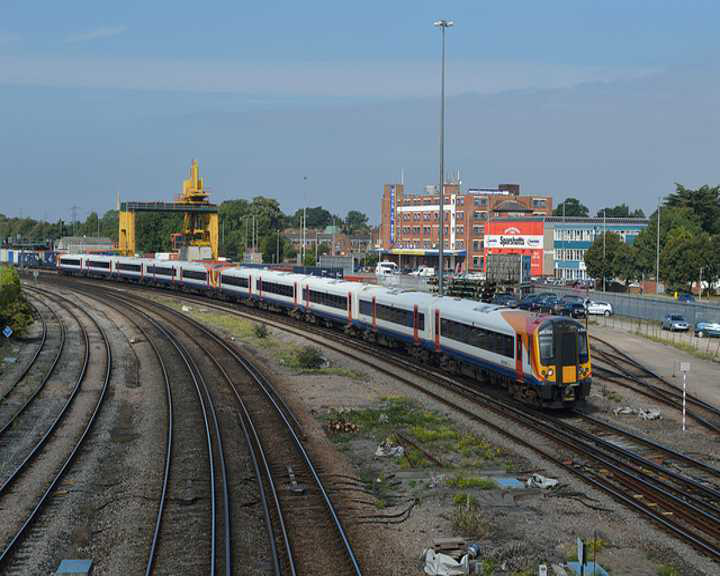

In [4]:
img = Image.open(DATASETS_PATH+"clean_base/000000000071.jpg")
img

In [17]:
def apply_noise(imga):
    imga = np.rot90(imga)

    imghla = rgb2hsv(imga)
    imgsat = imghla[:,:,2]
    imgsat = random_noise(imgsat,mode='gaussian', seed=RANDOM_STATE, var=0.01)
    imghla[:,:,2] = imgsat
    imga = hsv2rgb(imghla)

    imga = gaussian(imga, sigma=(1.3,0), multichannel=True)
    imga = np.rot90(imga, -1)
    return imga

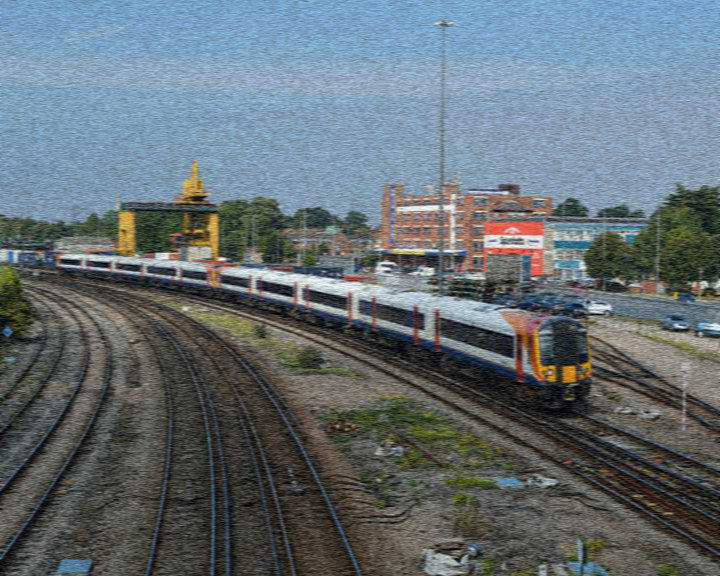

In [6]:
imga = np.interp(np.array(img).astype("float64"), (0,255), (0,1))
imga = apply_noise(imga)
Image.fromarray(np.interp(imga,(0,1), (0,255)).astype("uint8"))

In [7]:
def split_image(imgarray):
    subimages = np.split(imgarray, 3)
    i = []
    for sub in subimages:
        i += np.split(sub, 4, axis=1)
    subimages = i
    return subimages

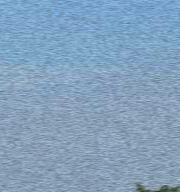

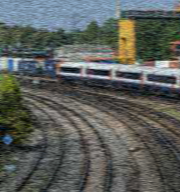

In [8]:
for img in split_image(imga)[3:5]:
    display(Image.fromarray(np.interp(img,(0,1), (0,255)).astype("uint8")))

Une fois toutes les images traités, nous nous retrouvons avec un ensemble d'environ 66000 images bruitées et non bruitées qui permettrons d'entrainer notre modèle.

#### Modèle de machine learning

Nous allons commencer par relever uniquement 10000 image aléatoires de nos images découpées dans la partie précédente.

Pour notre modèle de machine elarning, nous allons tout d'abord évaluer un modèle qui se contente de renvoyer l'image tel quel sans modification. Cela nous permettra de donner une base sur laquelle travailler et comparer

nsample, nx, ny, nz = X.shape
X_reg = X.reshape(nsample, nx*ny*nz)
y_reg = y.reshape(nsample, nx*ny*nz)
display(X_reg.shape)
display(y_reg.shape)

On remarque que cette solution implique d'entrainer 103680 SGDRegressor ce qui en fait une solution tres couteuse. Nous n'allons essayer de trouver une solution plus performante.

## CRISP Itération 2

Pour éviter cette solution, nous allons tenter de prédire un unique pixel sur la base des pixels voisins.
Pour ce faire nous allons conserver la même technique de machine learning avec SGBDRegressor() mais notre fonction de splitting sera actualisée pour génèrer une image avec un certain nombre de voisins.

In [ ]:
img = Image.open(DATASETS_PATH+"clean_base/000000000071.jpg")

imga = np.interp(np.array(img).astype("float64"), (0,255), (0,1))
imgn = apply_noise(imga)
Image.fromarray(np.interp(imgn,(0,1), (0,255)).astype("uint8"))

In [ ]:
train_filenames = !ls ../labs/noise-filter/clean_base
train_filenames = np.random.permutation(train_filenames)[:5]

def isolate_images(imga, img_name, n_neighbours=20):
    print("Isolating images with {} neighbours pixels".format(n_neighbours))
    inp = np.zeros((
        imga.shape[0] + (2*n_neighbours),
        imga.shape[1] + (2*n_neighbours),
        3
    ))
    inp[n_neighbours:-n_neighbours, n_neighbours:-n_neighbours, :] = imga
    isolated = 0
    print("Isolating 0/{} isolated pixels and neighbors".format(imga.shape[0]*imga.shape[1]), end="", flush=True)
    for x in range(n_neighbours,n_neighbours+imga.shape[0]):
        for y in range(n_neighbours,n_neighbours+imga.shape[1]):
            out = inp[
                x-n_neighbours:x+n_neighbours,
                y-n_neighbours:y+n_neighbours
            ]
            final_img = Image.fromarray(np.interp(out,(0,1), (0,255)).astype("uint8"))
            final_img.save(join(isolated_out,"{}_{}_{}.png".format(img_name, x-n_neighbours, y-n_neighbours)))
            isolated += 1
            
            if isolated % 10 == 0:
                print("\rIsolating {}/{} isolated pixels and neighbors".format(isolated, imga.shape[0]*imga.shape[1]), end="", flush=True)
    zero_img = Image.fromarray(np.interp(inp,(0,1), (0,255)).astype("uint8"))
    zero_img.save(join(isolated_out,"../{}.png".format(img_name, x, y)))
    print("\r{} images isolated                                                      ".format(imga.shape[0]*imga.shape[1]))

for filename in train_filenames:
    print("Isolating "+filename)
    img = Image.open(DATASETS_PATH+"clean_base/"+filename)
    imga = np.interp(np.array(img).astype("float64"), (0,255), (0,1))
    imgn = apply_noise(imga)
    isolate_images(imgn, filename.replace(".jpg",""), n_neighbours=NEIGHBOURS)
    print("")

In [ ]:
y = imga.reshape(-1,3)
display(y.shape)

In [ ]:
pixel_files = !ls ../labs/noise-filter/noisy_isolated

In [ ]:
def infer_metadata(filenames):
    full_filename = np.char.split(filenames, ".")
    full_filename = np.array([i[0] for i in full_filename])
    meta = np.char.split(full_filename,"_")
    meta = np.array([np.array(i) for i in meta])
    return meta

In [ ]:
shuffled_files = np.random.permutation(pixel_files)
train_batch = shuffled_files[:75_000]
test_batch = shuffled_files[75_001:][:1_0000]

display(train_batch[:10])
display(test_batch[:10])

In [ ]:
def get_data(images_filenames):
    X = []
    y = []
    
    metadata_list = infer_metadata(images_filenames)
    
    source_uniq = np.unique(metadata_list[:,0])
    source_img_dict = dict()
    print("Loading Source images 0/{} images".format(source_uniq.shape[0]), end="", flush=True)
    for i, source_img in enumerate(source_uniq):
        img = Image.open(join(source_path, source_img+".jpg"))
        source_img_dict[source_img] = np.interp(np.array(img).astype("float64"), (0,255), (0,1))
        print("\rLoading Source images {}/{} images".format(i+1,source_uniq.shape[0]), end="", flush=True)
    
    print("")
    
    loaded = 0
    print("Loading data {}/{} images".format(loaded,images_filenames.shape[0]), end="", flush=True)
    for meta, filename in zip(metadata_list, images_filenames):
        img = Image.open(join(isolated_out, filename))
        imga = np.interp(np.array(img).astype("float64"), (0,255), (0,1))
        source = source_img_dict[meta[0]]
        if int(meta[1]) < source.shape[0] and int(meta[2]) < source.shape[1]:
            y += [source[int(meta[1]), int(meta[2])]]
            X += [imga.flatten()]
            loaded += 1
        else:
            print("\nImage {} is out of bound of the source image {}".format(filename, meta[0]+".jpg"))
        if loaded % 100 == 0 :
            print("\rLoading data {}/{} images".format(loaded,images_filenames.shape[0]), end="", flush=True)
    print("")
    return (np.array(X), np.array(y))

In [ ]:
%%time
X, y = get_data(train_batch)
X_test, y_test = get_data(test_batch)

In [ ]:
display(X)
display(y)

### Modèle de Machine learning

L'objectif dans cette partie est de trouver un modèle de Machine Learning permettant de prédire la couleur d'un pixel (3 features) en prenant en compte ses voisins.
Pour ce faire, nous allons tenter de créer un Multioutput Regressor sur la base d'un Stochastic Gradient Decent.

In [ ]:
reg = MultiOutputRegressor(SGDRegressor(), n_jobs=-1)
reg.fit(X,y)

In [ ]:
y_predict = reg.predict(X_test)
mean_squared_error(y_test,y_predict)

In [ ]:
show_img(X[0].reshape(40,40,3))
display(y[0])

In [ ]:
def predict_image(reg, imga, single_input=False, n_neighbours=20):
    predicted = np.zeros(imga.shape)
    inp = np.zeros((
        imga.shape[0] + (2*n_neighbours),
        imga.shape[1] + (2*n_neighbours),
        3
    ))
    inp[n_neighbours:-n_neighbours, n_neighbours:-n_neighbours, :] = imga
    for x in range(n_neighbours,n_neighbours+imga.shape[0]):
        for y in range(n_neighbours,n_neighbours+imga.shape[1]):
            out = inp[
                x-n_neighbours:x+n_neighbours,
                y-n_neighbours:y+n_neighbours
            ]
            predicted[x-n_neighbours][y-n_neighbours] = reg.predict(np.array([out.flatten()]))[0]
    return predicted

In [ ]:
show_img(predict_image(reg, imgn, n_neighbours=NEIGHBOURS))

Hum... Il semble que ce soit pas tellement le résultat escompté. Nous allons tester avec un réseau de neurones.

In [ ]:
X.shape

In [ ]:
model = Sequential([
    Dense(20, input_shape=(NEIGHBOURS*NEIGHBOURS*4*3,), activation="relu"),
    Dense(10, activation='relu'),
    Dense(3, activation="relu")
])
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
model.summary()

In [ ]:
model.fit(X, y, epochs=20)

In [ ]:
show_img(predict_image(model, imgn, n_neighbours=NEIGHBOURS))

In [ ]:
show_img(imgn)

In [ ]:
test_img = Image.open("../dataset_clean_degraded/degraded/000000000081.jpg")
test_imga = np.interp(np.array(test_img).astype("float64"), (0,255), (0,1))
show_img(test_imga)

In [ ]:
show_img(predict_image(model, test_imga, n_neighbours=NEIGHBOURS))

In [ ]:
test_img = Image.open("../dataset_clean_degraded/degraded/000000033431.jpg")
test_imga = np.interp(np.array(test_img).astype("float64"), (0,255), (0,1))
show_img(test_imga)

In [ ]:
show_img(predict_image(model, test_imga, n_neighbours=NEIGHBOURS))

In [ ]:
model.save_weights('../libs/models/denoise/correction-weights.h5')
with open('../libs/models/denoise/correction-architecture.yml', 'w') as file:
    file.write(model.to_yaml())

# Detection

Dans cette parite, nous allons tenter de detecter si le bruis est présent sur une image ou non.

Dans notre cas nous allons séparer l'image en de multiples petites sous images que nous allons analyser une à une.
Cet ensemble d'image permettra de gèrer moins d'entrées dans les algorithmes est ainsi réduir la durée d'entrainement et de prédiction.
Mais cela peut aussi rendre notre algorithme moins performant dans le cas de la correction d'un détail de l'image.
Dans notre cas ce problème n'en est pas vraiment un car le bruit est uniformément réparti sur l'ensemble de l'image. Il n'y a donc pas de  détails à detecter.

Nous allons tout d'abord réutiliser la fonction de séparation prévue précédemment

In [4]:
def split_image(imgarray, x_split=3, y_split=4):
    subimages = np.split(imgarray, x_split)
    i = []
    for sub in subimages:
        i += np.split(sub, y_split, axis=1)
    subimages = i
    return subimages

In [5]:
SPLITS = (6, 6)
X, y = (None, None)

Nous allons ensuite tirer des images au hasard dans notre jeu de données clean pour les découper et ensuite les bruiter aléatoirement. Nout utiliserons le nom du fichier pour associer un label à chaque partie de l'image.

In [14]:
clean_source = !ls ../labs/noise-filter/clean_base
clean_source = np.random.permutation(clean_source)
source_files = clean_source[:2000]

In [12]:
print("Extracting splits")
for file in source_files:
    img = np.interp(img_path2array(source_path+"/"+file), (0,255), (0,1))
    imgname = file.replace(".jpg", "")
    splits = split_image(img, *SPLITS)
    noisy = True
    for i, split in enumerate(splits):
        
        if noisy:
            split = apply_noise(split)
            
        splitname = "{}-{}-{}.png".format(
            imgname,
            i,
            "noisy" if noisy else "clean"
        )
        img_array2file(join(detection_train_path, splitname), np.interp(split, (0,1), (0,255)).astype("uint8"))
        noisy = not noisy
    print("\rSplits from {} extracted            ".format(file), end="", flush=True)
print("\nFinished")

Extracting splits
Splits from 000000003992.jpg extracted            
Finished


Nous allons tout d'abord charger les données ainsi que leur label.

In [6]:
def load_classifyer_data(files):
    print("Loading {} files".format(len(files)))
    
    X = []
    y = []
    
    for i, file in enumerate(files):
        if i % 10 == 0:
            print("\rLoading {}            ".format(file), end="", flush=True)
        
        img = np.interp(img_path2array(detection_train_path+"/"+file), (0,255), (0,1))
        
        no_ext = file.split(".")[0]
        noisy = int(no_ext.split("-")[2] == "noisy")
        
        X += [
            np.array(img).flatten()
        ]
        
        y += [
            noisy
        ]
        
    print("")
    return (X, y)

In [7]:
base_files = !ls ../labs/noise-filter/detection_train
base_files = np.random.permutation(base_files)[:32000]
class_train_files = base_files[:30000]
class_test_files = base_files[30001:]

X, y = load_classifyer_data(class_train_files)
X_test, y_test = load_classifyer_data(class_test_files)

print("Shape of images : ", X[0].shape)
print("")
display(X[:10])
display(y[:10])

Loading 30000 files
Loading 000000008181-7-clean.png             
Loading 1999 files
Loading 000000025423-1-clean.png             
Shape of images :  (34560,)



[array([0.00392157, 0.        , 0.        , ..., 0.02745098, 0.00784314,
        0.01568627]),
 array([0.42352941, 0.36470588, 0.34901961, ..., 0.57647059, 0.48627451,
        0.4       ]),
 array([0.69411765, 0.69411765, 0.6627451 , ..., 0.0745098 , 0.0745098 ,
        0.0745098 ]),
 array([0.35686275, 0.48627451, 0.55686275, ..., 0.19215686, 0.26666667,
        0.20784314]),
 array([0.29411765, 0.3254902 , 0.14117647, ..., 0.17254902, 0.24705882,
        0.29411765]),
 array([0.10588235, 0.10588235, 0.10588235, ..., 0.86666667, 0.86666667,
        0.86666667]),
 array([0.77647059, 0.60392157, 0.48627451, ..., 0.53333333, 0.37254902,
        0.18039216]),
 array([0.89019608, 0.88627451, 0.89411765, ..., 0.18823529, 0.21176471,
        0.21176471]),
 array([0.05882353, 0.08235294, 0.08235294, ..., 0.0627451 , 0.13333333,
        0.14117647]),
 array([0.39215686, 0.27843137, 0.22745098, ..., 0.56078431, 0.43529412,
        0.38823529])]

[1, 1, 1, 1, 0, 1, 1, 1, 0, 1]

### Machine Learning

Maintenant, nous pouvons tester et entrainer notre algorithme LinearSVC.

In [ ]:
knn_class = KNeighborsClassifier()
knn_class.fit(X,y)

In [ ]:
y_test_predicted = knn_class.predict(X_test)
display(confusion_matrix(y_test,y_test_predicted))
print("Accuracy : ", accuracy_score(y_test,y_test_predicted))

Les resultat avec une accuracy de `0.82` peut encore être améliorée. On décide de continuer avec une classification par Décente de Gradient qui sera surement plus leger à utiliser .

In [ ]:
del knn_class

In [8]:
sgd_class = SGDClassifier()
sgd_class.fit(X,y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
y_test_predicted = sgd_class.predict(X_test)
display(confusion_matrix(y_test,y_test_predicted))
print("Accuracy : ", accuracy_score(y_test,y_test_predicted))

array([[1014,    0],
       [   2,  983]])

Accuracy :  0.9989994997498749


In [10]:
cross_val_score(sgd_class, X, y, cv=3)

KeyboardInterrupt: 

Les resultats, bien qu'assez extremes, sont tres bon et nous allons conserver ce modèle pour la detection final.

Il nous faut maintenant implémenter une fonction permettant de tester l'ensemble d'une image et non pas une simple portion de l'image.

In [65]:
def has_noise(img):
    results = []
    splits = split_image(img, *SPLITS)
    for split in splits:
        results += [sgd_class.predict([split.flatten()])]
    return (results)

1.0

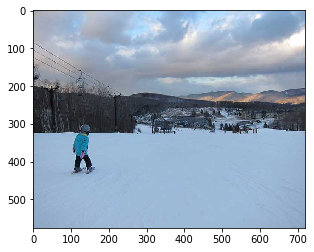

In [61]:
test_file_1 = img_path2array(source_path+"/"+clean_source[501])

test_file_1_result = has_noise(test_file_1)

display(plt.imshow(test_file_1))
display(test_file_1_result)

0.0

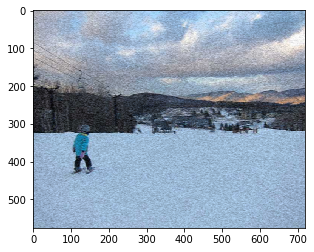

In [62]:
test_file_1_noisy = apply_noise(test_file_1)
test_file_1_noisy_result = has_noise(test_file_1_noisy)

display(plt.imshow(test_file_1_noisy))
display(test_file_1_noisy_result)

Result :  [array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([0]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([0]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1])] Expected : 0


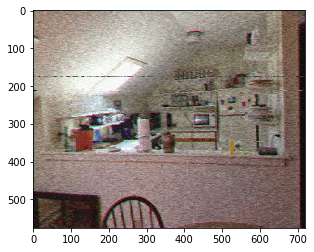

In [66]:
test_file_2 = img_path2array("../dataset_clean_degraded/degraded/000000000164.jpg")
test_file_2_result = has_noise(test_file_2)
display(plt.imshow(test_file_2))
print("Result : ",test_file_2_result, "Expected : 0")

Result :  [array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([0]), array([1]), array([0]), array([1])] Expected : 1


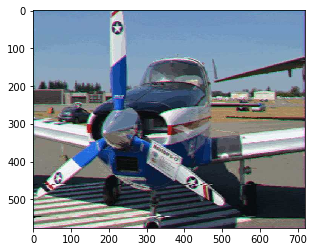

In [67]:
test_file_3 = img_path2array("../dataset_clean_degraded/degraded/000000000247.jpg")
test_file_3_result = has_noise(test_file_3)
display(plt.imshow(test_file_3))
print("Result : ",test_file_3_result, "Expected : 1")

Nous pouvons maintenant sauvegarder notre modèle

In [46]:
with open('../libs/models/denoise/detection-model.pickle', 'wb') as file:
    file.write(pickle.dumps(sgd_class))
print("Model saved")

Model saved
